<a href="https://colab.research.google.com/github/leadeeerq/Projects/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Flowers classification with Keras

##Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [3]:
tensorflow.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

###Setting the seed value

In [4]:
seed = 1842 #Ustawienie ziarna dla odtwarzalności wyników
tensorflow.random.set_seed(seed)
np.random.seed(seed)
warnings.simplefilter('ignore') #Wyłączenie ostrzeżeń

##Loading the data

In [5]:
image_generator = ImageDataGenerator(rescale = 1/255, validation_split = 0.2) #Skalowanie z 0-255 do 0-1

#Podział na zbiór treningowy i walidacyjny
train_dataset = image_generator.flow_from_directory( #flow_from_directory pobiera dane z folderów i automatycznie dzieli je na klasy
    batch_size = 32,
    directory = '/content/drive/MyDrive/Projekty/Computer Vision/data_cleaned/Train',
    shuffle = True,
    target_size = (224, 224),
    subset = 'training',
    class_mode = 'categorical'
)

validation_dataset = image_generator.flow_from_directory(
    batch_size = 32,
    directory = '/content/drive/MyDrive/Projekty/Computer Vision/data_cleaned/Train',
    shuffle = True,
    target_size = (224, 224),
    subset = 'validation',
    class_mode = 'categorical'
)

image_generator_submission = ImageDataGenerator(rescale = 1/255)
submission = image_generator_submission.flow_from_directory(
    directory = '/content/drive/MyDrive/Projekty/Computer Vision/data_cleaned/scraped_images/',
    shuffle = False,
    target_size = (224, 224),
    class_mode = None
)

Found 249 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


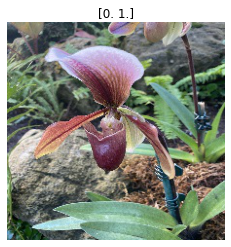

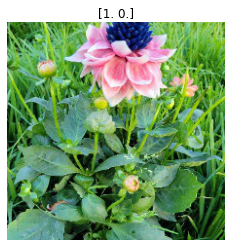

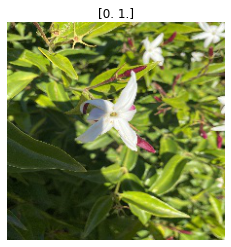

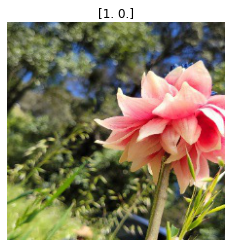

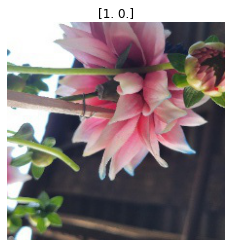

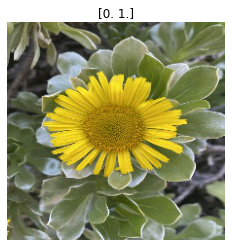

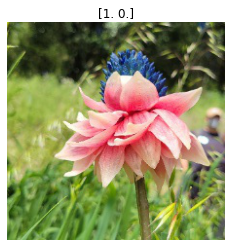

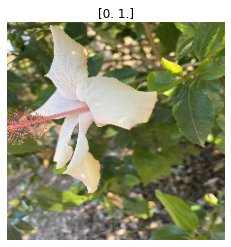

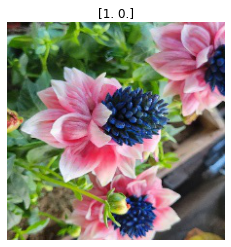

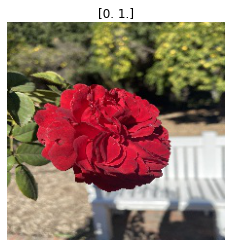

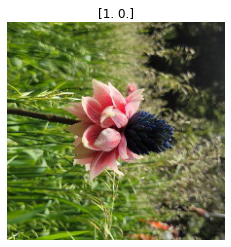

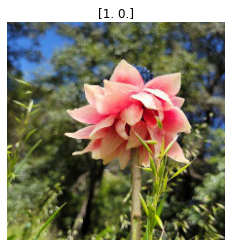

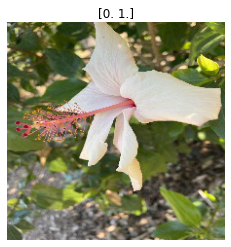

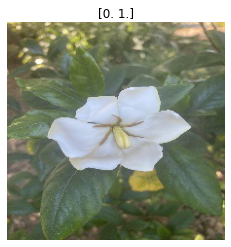

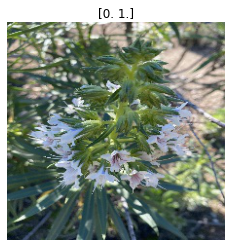

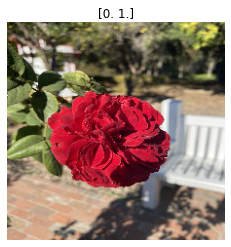

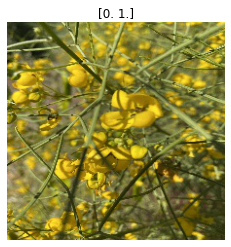

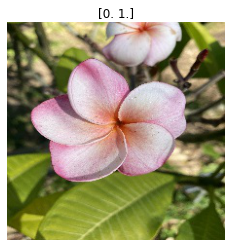

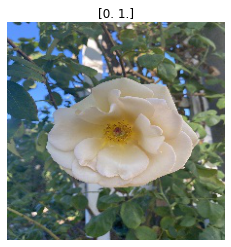

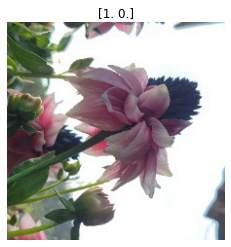

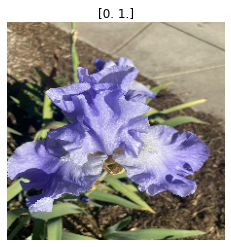

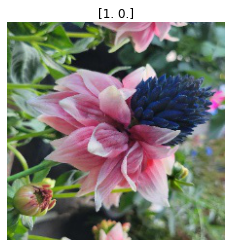

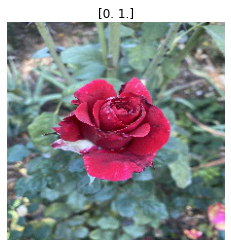

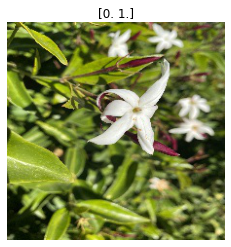

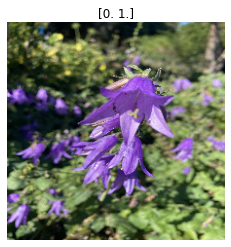

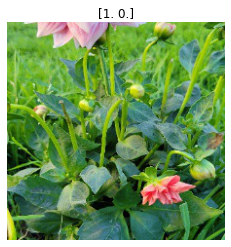

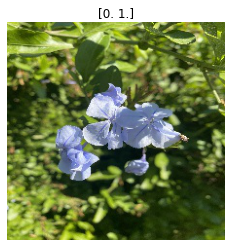

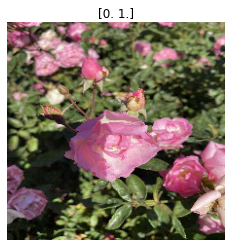

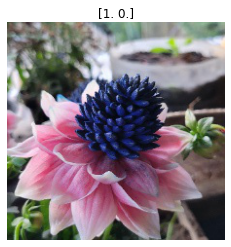

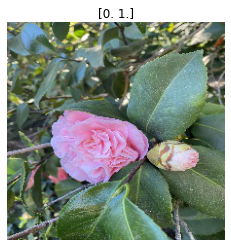

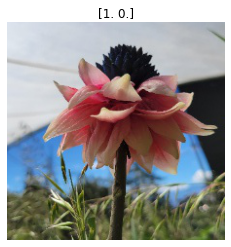

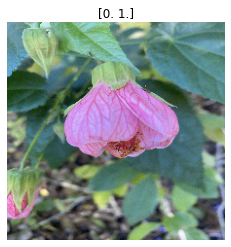

In [6]:
batch_1_img = train_dataset[0]
for i in range(0, 32):
  img = batch_1_img[0][i]
  lab = batch_1_img[1][i] #1 na pierwszym miejscu = la_eterna, 1 na drugim = inny gatunek
  plt.imshow(img)
  plt.title(lab)
  plt.axis('off')
  plt.show()

##Classifier (CNN - Convolutional Neural Network)

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, activation = 'relu', input_shape = (224, 224, 3)), #Obrazy RGB, więc x,y,3
    keras.layers.MaxPooling2D(), #Pobranie największej wartości z okna 2x2 (default)
    keras.layers.Conv2D(32, 3, activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(2, activation = 'softmax') #2 neurony wyjściowe
])

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', #funkcja straty dla dwóch wyjść
              metrics = ['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', #Zatrzymuje uczenie kiedy monitorowana metryka przestaje się poprawiać
                                         patience = 3,
                                         restore_best_weights = True)

In [8]:
model.fit(train_dataset, epochs = 20, validation_data = validation_dataset, callbacks = callback)

Epoch 1/20
8/8 [==============================] - 7s 240ms/step - loss: 0.8619 - accuracy: 0.5181 - val_loss: 0.6313 - val_accuracy: 0.6885
Epoch 2/20
8/8 [==============================] - 1s 142ms/step - loss: 0.6197 - accuracy: 0.6707 - val_loss: 0.4979 - val_accuracy: 0.8525
Epoch 3/20
8/8 [==============================] - 1s 140ms/step - loss: 0.4724 - accuracy: 0.8353 - val_loss: 0.3629 - val_accuracy: 0.8689
Epoch 4/20
8/8 [==============================] - 1s 144ms/step - loss: 0.2911 - accuracy: 0.8996 - val_loss: 0.3056 - val_accuracy: 0.8525
Epoch 5/20
8/8 [==============================] - 1s 142ms/step - loss: 0.1419 - accuracy: 0.9679 - val_loss: 0.2697 - val_accuracy: 0.8525
Epoch 6/20
8/8 [==============================] - 1s 140ms/step - loss: 0.0735 - accuracy: 0.9920 - val_loss: 0.5354 - val_accuracy: 0.8197
Epoch 7/20
8/8 [==============================] - 1s 149ms/step - loss: 0.0379 - accuracy: 0.9960 - val_loss: 0.4782 - val_accuracy: 0.8361
Epoch 8/20
8/8 [====

In [9]:
loss, accuracy = model.evaluate(validation_dataset)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

2/2 [==============================] - 0s 102ms/step - loss: 0.2697 - accuracy: 0.8525
Loss:  0.26968151330947876
Accuracy:  0.8524590134620667


##Image augmentation

- RandomCrop layer
- RandomFlip layer
- RandomTranslation layer
- RandomRotation layer
- RandomZoom layer
- RandomHeight layer
- RandomWidth layer
- RandomContrast layer
- RandomBrightness layer

In [10]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape = (224, 224, 3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1), #0.1*2pi
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    keras.layers.experimental.preprocessing.RandomContrast(0.1)
])

In [11]:
model_aug = keras.Sequential([
    data_augmentation,
    model
])

In [12]:
model_aug.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', #funkcja straty dla dwóch wyjść
              metrics = ['accuracy'])

In [13]:
model_aug.fit(train_dataset, epochs = 20, validation_data = validation_dataset, callbacks = callback)

Epoch 1/20


8/8 [==============================] - 5s 278ms/step - loss: 0.4804 - accuracy: 0.7912 - val_loss: 0.4259 - val_accuracy: 0.7869
Epoch 2/20
8/8 [==============================] - 2s 249ms/step - loss: 0.2933 - accuracy: 0.8956 - val_loss: 0.2859 - val_accuracy: 0.8689
Epoch 3/20
8/8 [==============================] - 2s 248ms/step - loss: 0.2389 - accuracy: 0.9116 - val_loss: 0.1663 - val_accuracy: 0.9836
Epoch 4/20
8/8 [==============================] - 2s 256ms/step - loss: 0.2036 - accuracy: 0.9116 - val_loss: 0.2059 - val_accuracy: 0.9344
Epoch 5/20
8/8 [==============================] - 2s 243ms/step - loss: 0.1490 - accuracy: 0.9478 - val_loss: 0.1938 - val_accuracy: 0.9016
Epoch 6/20
8/8 [==============================] - 2s 254ms/step - loss: 0.1437 - accuracy: 0.9598 - val_loss: 0.2084 - val_accuracy: 0.9344


In [14]:
loss, accuracy = model.evaluate(validation_dataset)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

2/2 [==============================] - 0s 98ms/step - loss: 0.1663 - accuracy: 0.9836
Loss:  0.16625286638736725
Accuracy:  0.9836065769195557


##Keras tuner

In [15]:
pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
train_images = []
train_labels = []

for i in range(len(train_dataset)):
  batch = train_dataset[i]
  # print(len(batch[0]))
  for j in range(len(batch[0])):
    train_images.append(batch[0][j])
    train_labels.append(batch[1][j])

validation_images = []
validation_labels = []

for i in range(len(validation_dataset)):
  batch = validation_dataset[i]
  # print(len(batch[0]))
  for j in range(len(batch[0])):
    validation_images.append(batch[0][j])
    validation_labels.append(batch[1][j])

train_images = np.array(train_images)
train_labels = np.array(train_labels)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

In [22]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
  model = keras.Sequential([data_augmentation])
  
  model.add(keras.layers.AveragePooling2D(4, 2)) #Uśrednianie pikseli w "oknie" o wymiarach 6x6 px i przesuwanie okna o 3 px,
                                #Prowadzi to do "zmniejszenia" obrazu do wymiarów 100x100 (z 300x300)
  
  for i in range(hp.Int("Convolutional layers", min_value = 0, max_value = 3)):
    model.add(keras.layers.Conv2D(hp.Choice(f"Layer {i} filters", [16, 32, 64]), kernel_size = 3, activation = 'relu')) #Kernel_size to rozmiar "okienka" 3x3 px
    model.add(keras.layers.MaxPool2D(3,3)) #Pobranie maksymalnej wartości piksela z "okienka" 3x3 px

  model.add(keras.layers.Dropout(0.5)) #Podczas uczenia 50% połączeń między neuronami jest odcinanych losowo; każde połączenie będzie lepiej uogólniać
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256]), activation = 'relu'))

  model.add(keras.layers.Dense(2, activation = 'softmax'))

  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model

tuner = RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 32,
)

In [23]:
tuner.search(train_images, train_labels, validation_data = (validation_images, validation_labels), epochs = 10, batch_size = 32)

In [24]:
best_model = tuner.get_best_models()

ValueError: ignored

In [ ]:
best_model.summary()

In [ ]:
loss, accuracy = best_model.evaluate(validation_dataset)

print("LOSS", loss)
print("ACCURACY", accuracy)

##Creating submission

In [ ]:
onlyfiles = [f.split('.')[0] for f in s.listdir(os.path.join('/content/drive/MyDrive/Projekty/Computer Vision/data_cleaned/scraped_images/image_files')) if os.path.isfile(os.path.join(os.path.join('data_cleaned/scraped_images/image_files'), f))]
submission_df = pd.DataFrame(onlyfiles, columns =['images'])
submission_df[['la_eterna','other_flower']] = best_model.predict(submission)
submission_df.head()

In [ ]:
submission_df.to_csv('submission_file.csv', index = False)